# Olá!

Este é o meu notebook e é fruto do trabalho conjunto da equipe "Resiliência em ML" para a competição VLabs Data Challenge, onde deseja-se prever o LTV dos próximos 90 dias aberto por cliente a partir de 14 meses de dados de compras em diferentes canais. 

A equipe é composta por:
- Marcos Mansur
- Thiago Ouverney
- Aron Alvernaz
- Lucas Valim

Esse notebook retrata o modelo com melhor score que fizemos.

# Carregar Libs

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score, train_test_split, learning_curve, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import make_pipeline


# Carregar dados

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/VLabs-DC/sales_20_21_train.csv
/kaggle/input/VLabs-DC/sample_submission.csv


In [3]:
df = pd.read_csv('/kaggle/input/VLabs-DC/sales_20_21_train.csv', header=0, parse_dates=['DT_VENDA'])
# df = pd.read_csv('https://raw.githubusercontent.com/marcos-mansur/vlabs-challenge/main/Data/sales_20_21_train.csv', header=0, parse_dates=['DT_VENDA'])
df_sub = pd.read_csv('/kaggle/input/VLabs-DC/sample_submission.csv',header=0)

In [4]:
df.head()

,ID_VENDA,DT_VENDA,LOJA,QTD_SKU,VALOR,ID_CLIENTE,CANAL
0,1176550,2020-01-02,37,1,9.50,337763,FIS
1,11683461,2020-01-02,15,1,6.64,195687,FIS
2,3326484,2020-01-02,29,5,446.87,56059,FIS
3,7317475,2020-01-02,18,1,6.13,297533,FIS
4,4366938,2020-01-02,23,1,13.17,181284,FIS


# Funções

## Plot curvas de aprendizado

In [5]:
def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate plot: learning curve

    """
    if axes is None:
        _, axes = plt.subplots(1, figsize=(20, 10))

    axes.set_title(title)
    if ylim is not None:
        axes.set_ylim(*ylim)
    axes.set_xlabel("Training examples")
    axes.set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes, scoring='neg_root_mean_squared_error',
                       return_times=True)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes.grid()
    # plot intervalos de spread 
    axes.fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes.fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    # curvas
    axes.plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes.plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes.legend(loc="best")
    return plt

## Pré-processamento

In [6]:
def split_per_dates(df,train_start,target_start, sub_start):
    " divide os dados de treino, validação e submissão por data"
    # target do treinamento
    df_target = df[df.DT_VENDA > target_start]
    y_train = df_target.groupby('ID_CLIENTE')['VALOR'].sum()
    # dados de treinamento
    df_train = df[(df['DT_VENDA']>train_start) & (df['DT_VENDA']<target_start)].copy()
    # dados para previsão
    df_test = df[df['DT_VENDA']>sub_start]
    return df_train, y_train, df_test

def treated_data(df_pp):
    " transforma o dataset aberto por compras ordenado no tempo "
    " em um dataset por cliente e cria features úteis"
    
    # intervalos de tempo
    delta90 = pd.to_timedelta(90,unit='d')
    delta120 = pd.to_timedelta(120,unit='d')
    delta150 = pd.to_timedelta(150,unit='d')
    delta180 = pd.to_timedelta(180,unit='d')
    delta360 = pd.to_timedelta(360,unit='d')
    delta270 = pd.to_timedelta(270,unit='d')

    DICT_AUX_DATAS = {'90':delta90,
                      '120':delta120,
                      '150':delta150,
                      '180':delta180}

    max_date = df_pp['DT_VENDA'].max()
    
    #agrupar por cliente somando o valor
    cust_revenue = df_pp.groupby(['ID_CLIENTE'])['VALOR'].sum().copy()
    # transformar em df
    cust_rev = pd.DataFrame(cust_revenue)
    # feature com número de compras feitas no período de teste
    cust_rev['Frequency'] = df_pp.groupby(['ID_CLIENTE'])['ID_VENDA'].count()


    # media entre os valores das compras de cada cliente
    cust_rev['valor medio'] = df_pp.groupby('ID_CLIENTE')['VALOR'].mean()
    # mediana
    cust_rev['valor mediana'] = df_pp.groupby('ID_CLIENTE')['VALOR'].median()
    # desvio padrao
    cust_rev['valor desvio'] = df_pp.groupby('ID_CLIENTE')['VALOR'].std()
    
    
    # data da ultima compra
    cust_rev['Recency'] = max_date - df_pp.groupby(['ID_CLIENTE'])['DT_VENDA'].max()
    cust_rev['Recency'] = cust_rev['Recency'].apply(lambda x: x.days)
    
    # soma e média do VALOR de diferentes períodos de cada cliente    
    for item, valor in DICT_AUX_DATAS.items():
        cust_rev[f'valor_{item}m'] = df_pp[
              df_pp['DT_VENDA']>(df_pp['DT_VENDA'].max() - valor)].groupby(['ID_CLIENTE'])['VALOR'].sum()
        cust_rev[f'valormedio_{item}m'] = df_pp[
              df_pp['DT_VENDA']>(df_pp['DT_VENDA'].max() - valor)].groupby(['ID_CLIENTE'])['VALOR'].mean()

    # soma do valor de 3 meses há 1 ano atrás 
    ref = df_pp['DT_VENDA'].max()
    cust_rev[f'valorsum_1ano_atras_m'] = df_pp[
            (df_pp['DT_VENDA'] < (ref - delta270) ) &
           (df_pp['DT_VENDA'] > (ref - delta360) )
            ].groupby(['ID_CLIENTE'])['VALOR'].sum()
            
    return cust_rev.fillna(0)

def transform_df(df):
    df = df.copy()
    
    # divide os dados de treino e previsão pela data
    df_train, target_train, df_test = split_per_dates(df,train_start,target_start,sub_start)
    # modifica o df e cria features nos dados de treino
    df_train1 = treated_data(df_train)
    # para alinhar o index do target do treino com os dados de treino
    df_train2 = df_train1.join(other=target_train, on='ID_CLIENTE', lsuffix='_sum', rsuffix='_TARGET')
    x_train = df_train2.drop('VALOR_TARGET',axis=1)
    y_train = df_train2.VALOR_TARGET.fillna(0)
    
    # modifica o df e cria features nos dados de test
    x_test = treated_data(df_test)
    return x_train, y_train, x_test

# Estratégia

Primeiro, vamos dividir os dados por data em x de treino (período dos dados para treinar o modelo), y de treino (o período do target do treino) e x de teste (o período para gerar a previsão dos próximos 90 dias).

Para treinar o modelo, usaremos todo os dados menos as compras dos ultimos 90 dias, que serão o target do trieno. Para explicitar a tendência mais recente dos dados para o modelo, agrupamos os valores dos últimos 3, 4, 5 e 6 meses criado features (variáveis) com a soma, média e desvio padrão do valor das compras nesses períodos. Afim de transmitir a sazonalidade anual para o modelo, criamos uma feature com a soma das compras dos 3 meses do ano anterior. Essa última melhorou a performance significativamente. 

In [7]:
# intervalo de 90 dias
delta90 = pd.to_timedelta(90,unit='d')
# data mais recente do dataset
max_date = df['DT_VENDA'].max()
# data de início do target
target_start = max_date - delta90
# data de início dos dados de treino
train_start = target_start - 5*delta90
# data de início dos dados de previsão (submissão)
sub_start = max_date - 5*delta90

# Pré-processamento

Transformar o dataset original no formato próprio para previsão.

In [8]:
x_train_total, y_train_total, x_test = transform_df(df)
x_train_split, x_test_split, y_train_split, y_test_split = train_test_split(x_train_total, 
                                                                            y_train_total, 
                                                                            random_state=0,
                                                                            test_size=0.3)

In [9]:
x_train_total.head()

,VALOR_sum,Frequency,valor medio,valor mediana,valor desvio,Recency,valor_90m,valormedio_90m,valor_120m,valormedio_120m,valor_150m,valormedio_150m,valor_180m,valormedio_180m,valorsum_1ano_atras_m
ID_CLIENTE,,,,,,,,,,,,,,,
0,266.94,1,266.940000,266.940,0.000000,56,266.94,266.94,266.94,266.94,266.94,266.94,266.94,266.94,0.00
2,426.45,4,106.612500,105.285,75.738965,151,0.00,0.00,0.00,0.00,0.00,0.00,104.69,104.69,121.08
3,215.06,3,71.686667,42.790,61.268823,104,0.00,0.00,30.21,30.21,30.21,30.21,30.21,30.21,184.85
4,714.65,7,102.092857,46.440,167.318644,16,532.64,266.32,532.64,266.32,532.64,266.32,532.64,266.32,111.51
5,47.19,1,47.190000,47.190,0.000000,237,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [10]:
y_train_total.head()

ID_CLIENTE
0    369.35
2    235.81
3      0.00
4    557.22
5      0.00
Name: VALOR_TARGET, dtype: float64

In [11]:
x_test.head()

,VALOR,Frequency,valor medio,valor mediana,valor desvio,Recency,valor_90m,valormedio_90m,valor_120m,valormedio_120m,valor_150m,valormedio_150m,valor_180m,valormedio_180m,valorsum_1ano_atras_m
ID_CLIENTE,,,,,,,,,,,,,,,
0,636.29,2,318.145000,318.145,72.414805,84,369.35,369.350,369.35,369.350,636.29,318.145000,636.29,318.145000,0.00
2,662.26,6,110.376667,105.285,79.194434,49,235.81,117.905,235.81,117.905,235.81,117.905000,235.81,117.905000,200.68
3,215.06,3,71.686667,42.790,61.268823,195,0.00,0.000,0.00,0.000,0.00,0.000000,0.00,0.000000,0.00
4,1271.87,11,115.624545,59.010,134.009345,16,557.22,139.305,610.01,122.002,1089.86,181.643333,1089.86,181.643333,70.50
5,47.19,1,47.190000,47.190,0.000000,328,0.00,0.000,0.00,0.000,0.00,0.000000,0.00,0.000000,47.19


# Modelo - ElasticNet

Usaremos um modelo linear com regularizações l1 e l2 vizando minimizar o impacto dos ruídos dos dados, do ruído inerente a prever valores futuros a partir de uma quantidade e variedade limitada de dados que muito provavelmente não carrega toda a variância dos dados e o impacto da correlação das variáveis que criamos nos pesos da regressão.

In [12]:
en = ElasticNet(random_state=0)
en.fit(x_train_split, y_train_split)
en_pred = en.predict(x_test_split)
# validação direta
score_dir = mean_squared_error(y_test_split,en_pred, squared=False)
print('Validação direta RMSE: ',score_dir)

Validação direta RMSE:  242.17955974579021


In [13]:
# validação cruzada
score = cross_val_score(en, X=x_train_total, y=y_train_total, cv=5, scoring='neg_root_mean_squared_error')
print('RMSE: ',-score.mean(), '\nstd = :', score.std())

RMSE:  245.95534755944885 
std = : 17.352346333988397


O desvio padrão alto indica que o modelo está muito sensível ao conjunto de dados usado. Variar a random_seed do train_test_split também altera significativamente o score, o que reforça essa ideia.

<module 'matplotlib.pyplot' from '/opt/conda/lib/python3.7/site-packages/matplotlib/pyplot.py'>

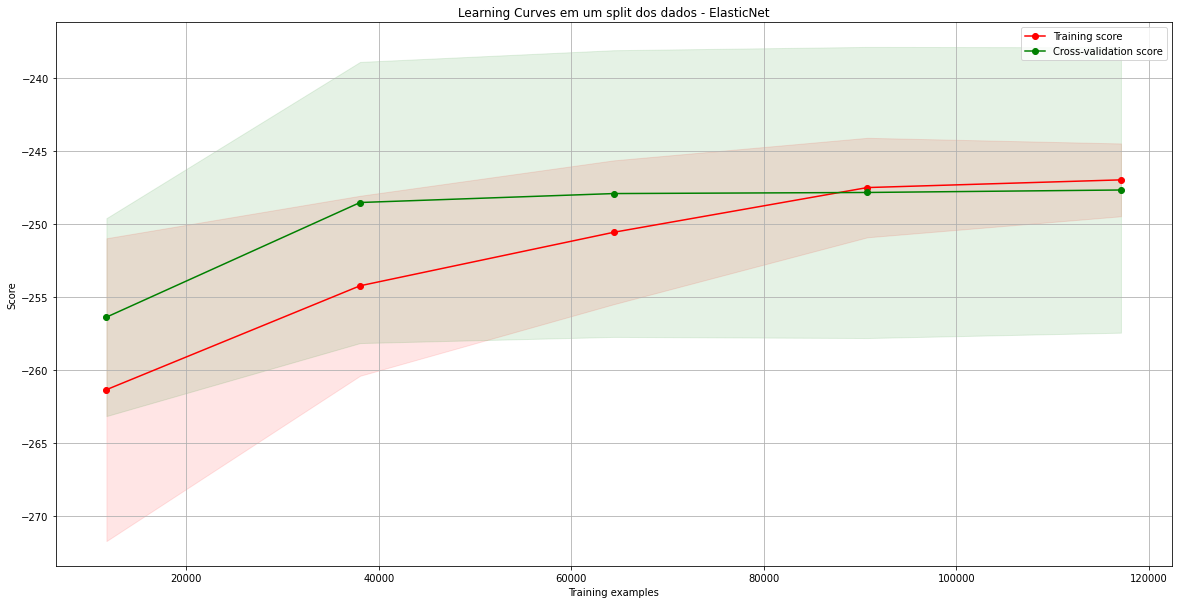

In [14]:
# plot curva de aprendizado com 70% dos dados
title = "Learning Curves em um split dos dados - ElasticNet"
plot_learning_curve(ElasticNet(random_state=0), title, x_train_split, y_train_split, cv=5, n_jobs=-1)

Curva de aprendizado com 70% dos dados não indica overfitting, coerente com aprendizado real.

<module 'matplotlib.pyplot' from '/opt/conda/lib/python3.7/site-packages/matplotlib/pyplot.py'>

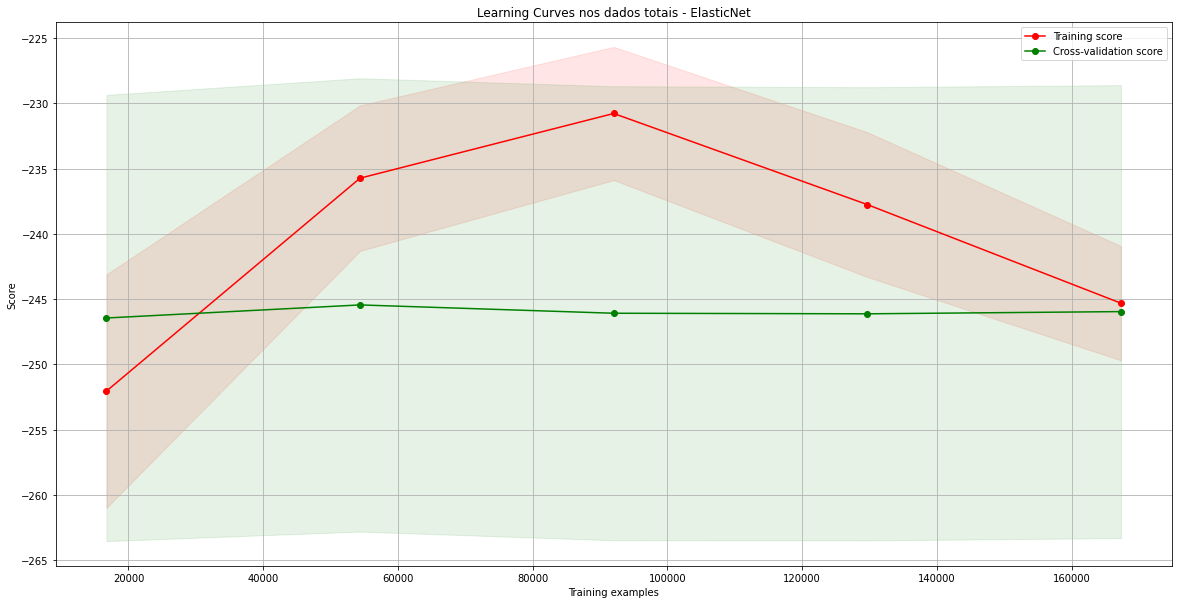

In [15]:
# curva de aprendizado com todos os dados
title = "Learning Curves nos dados totais - ElasticNet"
plot_learning_curve(ElasticNet(random_state=0), title, x_train_total, y_train_total, cv=5, n_jobs=-1)

Não sei o que ta acontecendo aqui kkkkkkkk

# Dividindo por canal

Os padrões de compras em lojas físicas, por televendas, whatsapp, ecm e ifood são diferentes, por isso, treinamos um modelo com as compras de cada canal e somamos as previsões finais. Essa solução deu uma pontuação muito semelhante (diferença de décimos no leaderboard) a treinar apenas um modelo com os dados de todos os canais, mas como é um pouco mais elaborada, resolvi compartilhar essa.

In [16]:
canais = df['CANAL'].unique()
# define listas para receber os dados separados por canal
x_train_aux = [[] for x in range(len(canais))]
y_train_aux = [[] for x in range(len(canais))]
x_test_aux = [[] for x in range(len(canais))]

# divide o dataset por canal
for i, canal in enumerate(canais):
    df_aux = df[df['CANAL']==canal]
    x_train_aux[i], y_train_aux[i], x_test_aux[i] = transform_df(df_aux)

In [17]:
for i,canal in zip(range(5),canais): 
    print(canal, x_train_aux[i].shape)

FIS (176452, 15)
TELEVENDAS (5764, 15)
ECM (36846, 15)
WHATSAPP (2921, 15)
IFOOD (1247, 15)


In [18]:
# cria lista de modelos
modelos = [ElasticNet(random_state=0) for x in range(len(canais))]
# lista para receber as predições
preds = [[] for x in range(len(canais))]

In [19]:
# treina e faz a previsão para cada modelo
for i, modelo in enumerate(modelos):
    preds[i] = modelo.fit(x_train_aux[i], y_train_aux[i]).predict(x_test_aux[i])

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 93772119.45816168, tolerance: 87201.48240262679
  positive)
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 19784006.713751584, tolerance: 48474.09224963906
  positive)
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2740330.686439343, tolerance: 6620.535482075572
  positive)


In [20]:
# cria lista para receber as previsões transformadas para dataframe
df_preds=[[] for x in range(5)]
for i, canal in enumerate(canais):
    df_preds[i] = pd.DataFrame(preds[i], index=x_test_aux[i].index)

df_sub = pd.read_csv('/kaggle/input/VLabs-DC/sample_submission.csv',header=0)
# Join nas previsões dos diferentes canais
for prediction in df_preds:
     df_sub = df_sub.join(prediction,on='ID_CLIENTE', lsuffix='_sum', rsuffix='_TARGET')

# soma as previsões dos canais em uma coluna "FINAL"
df_sub['FINAL'] = df_sub.iloc[:,1:].sum(axis=1)
# drop nas previsões para ficar só a soma
df_sub.drop(list(df_sub.columns[1:-1]),axis=1,inplace=True)
# corrige o nome das colunas para submissão
df_sub.columns = ['ID_CLIENTE','VALOR']

/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:9139: FutureWarning: Passing 'suffixes' which cause duplicate columns {'0_sum'} in the result is deprecated and will raise a MergeError in a future version.
  sort=sort,


In [21]:
df_sub

,ID_CLIENTE,VALOR
0,4,414.441001
1,9,91.310892
2,12,297.516923
3,15,223.847468
4,19,87.293143
...,...,...
126611,384409,61.378438
126612,384411,143.194911
126613,384415,59.601366
126614,384418,166.557001


Outro meio usado para validar vagamente a predição antes de gastar uma submissão no kaggle foi comparar com a melhor submissão que tínhamos até o momento.

In [22]:
# melhor score na public leaderboard
#df_sub5 = pd.read_csv(r'C:\Users\mmansur\VLabs\Submissions\best_score.csv')

# validação direta
#score_dir = mean_squared_error(df_sub5,df_sub, squared=False)
#print('Validação direta RMSE: ',score_dir)

Esse código não vai rodar aqui, foi feito localmente. Retornou RMSE = 20.26 em relação à melhor previsão que tínhamos (um modelo mais simples, com menos features), o que quer dizer que está no caminho certo, vai melhorar ou piorar um poquinho a melhor solução até o momento. Nesse caso, melhorou o RMSE em ~7 pontos.

# Submissão

In [23]:
df_sub.to_csv('submission_VLabs.csv', index=False)

# Próximos passos

Pontos a melhorar:
- investigar cada feature individualmente, se está ajudando ou atrapalhando. 
- suavizar outliers vizando melhorar a performance de modelo linear
- testamos uma normalização que não funcionou bem, há mais para explorar em relação a normalizações
- investigar distribuição das variáveis. Aplicar transformações vizando aproximar de uma distriução normal pode melhorar modelos lineares
- hyperparameter tuning, principalmente alpha e l1_rate
- produzir diferentes modelos e stackar utilizando as soluções como input